In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

# Initial setup

## Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

## Cross entropy loss

In [9]:
def log_softmax(x):
    numrtr = x.exp()
    dnmntr = x.exp().sum(-1, keepdim=True)
    return (numrtr/dnmntr).log()

we use log at the end because NLL in pytorch expects logs

In [10]:
sm_pred = log_softmax(pred) #softmaxed predictions

cross entropy loss is $- \sum{x \log{p(x)}}$. How do we code it in an efficient way to prevent multiplications by zeros (9 times in this case for each input)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred.shape

torch.Size([50000, 10])

In [13]:
sm_pred[0]

tensor([-2.3849, -2.1429, -2.4367, -2.3200, -2.3596, -2.3186, -2.1348, -2.4767,
        -2.2644, -2.2460], grad_fn=<SelectBackward>)

In [15]:
sm_pred[0][5]

tensor(-2.3186, grad_fn=<SelectBackward>)

In [16]:
# so here basically we are taking the first 3 rows and getting the corresponding columns

In [19]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.3186, -2.3587, -2.3256], grad_fn=<IndexBackward>)

In [20]:
y_train.shape[0]

50000

In [21]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [22]:
loss = nll(sm_pred, y_train)

In [23]:
loss

tensor(2.3057, grad_fn=<NegBackward>)

How can we improve the softmax formula?

In [24]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [25]:
test_near(nll(log_softmax(pred), y_train), loss)

We can use logsumexp trick here - we should not use e^x much - computers don't handle large numbers well

In [26]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [27]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we should use it for our `log_softmax` function

In [28]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [29]:
test_near(nll(log_softmax(pred), y_train), loss)

Now we can use pytorch's implementation

In [30]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In pytorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function `F.cross_entropy`

In [31]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss w.r.t. every parameter of the model
- update said parameters with those gradients to make them better

In [32]:
loss_func = F.cross_entropy

In [33]:
#export
def accuracy(out, yb):
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [34]:
bs = 64 #batch size
xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # predictions
preds[0], preds.shape

(tensor([-0.0909,  0.1510, -0.1428, -0.0261, -0.0657, -0.0246,  0.1591, -0.1827,
          0.0295,  0.0480], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [37]:
# preds.shape is [64,10] because batch of 64 and 10 probs per input

In [35]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.2958, grad_fn=<NllLossBackward>)

In [36]:
accuracy(preds, yb)

tensor(0.1406)

accuracy is about 10% because model is not trained - so we expect it to be as good as random

In [38]:
lr = 0.5 # learning rate
epochs = 1 # how many epochs to train for

`torch.no_grad()` is used because the update is not part of the gradient calculation - it's the use of these gradients - it's the result

In [39]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [40]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1716, grad_fn=<NllLossBackward>), tensor(0.9375))

In [41]:
# note that this accuracy is only for a single mini batch

# Using parameters and optim

## Doing it by hand

In [44]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [45]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [50]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [46]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Doing it with `nn.Module`

In [47]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [48]:
model = Model(m, nh, 10)

In [49]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [51]:
# model.named_children() is same as mdl._modules that we created above

In [52]:
model #pytorch's __repr__

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [56]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [57]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0754, grad_fn=<NllLossBackward>), tensor(1.))

## Registering Modules

We can use the original `layers` approach, but we have to register the modules

In [58]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [59]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [60]:
model = Model(layers)

In [61]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

`nn.ModuleList` does this for us

In [62]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [63]:
model = SequentialModel(layers)

In [64]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [65]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2920, grad_fn=<NllLossBackward>), tensor(0.9375))

## nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [66]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [67]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [68]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2310, grad_fn=<NllLossBackward>), tensor(0.9375))

In [70]:
nn.Sequential??

## optim
Use pytorch's optim

In [71]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [72]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [74]:
model.parameters()

<generator object Module.parameters at 0x7fcfa0593bd0>

In [73]:
opt = Optimizer(model.parameters())

In [76]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [77]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0497, grad_fn=<NllLossBackward>), tensor(1.))

pytorch already has optim.SGD (it also has extra things like momentum and weight_decay

In [78]:
#export
from torch import optim

In [79]:
optim.SGD.step??

In [80]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [81]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2868, grad_fn=<NllLossBackward>)

In [82]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [83]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0928, grad_fn=<NllLossBackward>), tensor(1.))

Randomized tests can be very useful

In [84]:
assert acc>0.7

# Dataset and DataLoader

In [85]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [86]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [87]:
xb, yb = train_ds[0:5]
assert xb.shape==(5, 28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [88]:
model, opt = get_model()

In [89]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [90]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.0983, grad_fn=<NllLossBackward>), tensor(0.9375))

## DataLoader

In [91]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [92]:
#yield is a co-routine - something that returns different values every time it is called

In [93]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [94]:
xb, yb = next(iter(valid_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape==(bs,)

tensor(3)

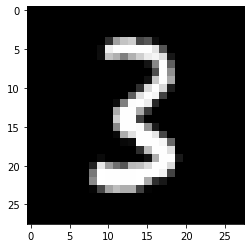

In [95]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [96]:
model, opt = get_model()

In [97]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [98]:
fit()

In [99]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.0638, grad_fn=<NllLossBackward>), tensor(0.9844))

## Random sampling

We want our training data to be randomized in each iteration but not the validation data

In [100]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        if self.shuffle:
            self.idxs = torch.randperm(self.n)
        else:
            self.idxs = torch.arange(self.n)
        
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

In [104]:
small_ds = Dataset(*train_ds[:10])

In [105]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [106]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([2, 1, 6]), tensor([0, 9, 3]), tensor([7, 5, 8]), tensor([4])]

In [107]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [108]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [109]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

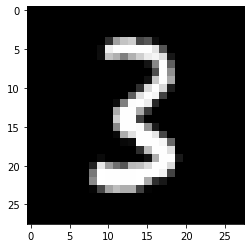

In [110]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

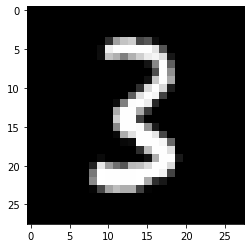

In [113]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

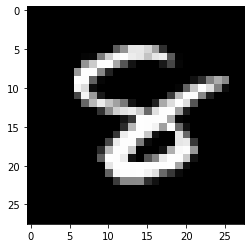

In [111]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

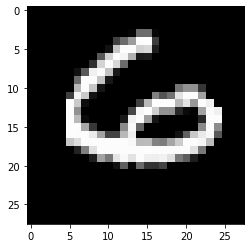

In [112]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [114]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.0862, grad_fn=<NllLossBackward>), tensor(0.9844))

## PyTorch DataLoader

In [115]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [116]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [117]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1810, grad_fn=<NllLossBackward>), tensor(0.9219))

In [118]:
#using defaults from pytorch
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [119]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1043, grad_fn=<NllLossBackward>), tensor(0.9844))

# Validation

In [122]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm/dropout
        model.train()
        # print(model.training)
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        # print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [123]:
# model.train and model.eval set model.training to True and False respectively

The problem here is that metrics will be incorrect when batch size varies - example last batch in a dataset

In [124]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Validation data loader does not need to store the gradients, that means it has twice the space, and we can double the batchsize

Entire process of obtaining the data loaders and fitting the model in 3 lines of code:

In [125]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1568) tensor(0.9517)
1 tensor(0.1523) tensor(0.9513)
2 tensor(0.0944) tensor(0.9709)
3 tensor(0.1115) tensor(0.9652)
4 tensor(0.0887) tensor(0.9737)


In [126]:
assert acc>0.9

# Export

In [127]:
!python notebook2script.py 03_minibatch_training.ipynb

converted 03_minibatch_training.ipynb to nb_03.py
